In [1]:
import os
import boto3
import bz2
import json
import io
import math
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["AWS_ACCESS_KEY_ID"] = "REDACTED"  
os.environ["AWS_SECRET_ACCESS_KEY"] = "REDACTED" 
os.environ["AWS_REGION"] = "us-east-1"  # Default aws region

S3_BUCKET = "shot-probability"
s3_client = boto3.client("s3")

atk_all = pd.read_parquet(f"s3://{S3_BUCKET}/pl_2022-2025.parquet", engine='pyarrow')
atk_all

,r,theta,z,speed,GK_r,GK_theta,openGoal,DefDist0,DefAngle0,OffDist0,...,shot_proba,goal_proba,int_sec,gameId,home_id,home_name,away_id,away_name,date,attack_team_name
0,36.632069,0.942201,1.34,0.000000,7.535576,0.752080,0.691115,2.443856,1.300309,5.508077,...,0.001206,0.000059,45,4436,7,Crystal Palace,2,Arsenal,2022-08-05 19:00:00,Crystal Palace
1,36.655604,0.941318,1.52,1.198789,7.529676,0.750269,0.684063,2.423591,1.313809,5.544241,...,0.000816,0.000041,45,4436,7,Crystal Palace,2,Arsenal,2022-08-05 19:00:00,Crystal Palace
2,36.693140,0.940377,1.52,1.528162,7.523800,0.748455,0.677959,2.413045,1.332753,5.594073,...,0.000816,0.000041,45,4436,7,Crystal Palace,2,Arsenal,2022-08-05 19:00:00,Crystal Palace
3,36.716733,0.939497,1.64,1.198825,7.517949,0.746637,0.670869,2.397010,1.346562,5.630581,...,0.000816,0.000041,45,4436,7,Crystal Palace,2,Arsenal,2022-08-05 19:00:00,Crystal Palace
4,36.740355,0.938618,1.64,1.198789,7.512801,0.744915,0.663881,2.383186,1.361139,5.666987,...,0.000816,0.000041,45,4436,7,Crystal Palace,2,Arsenal,2022-08-05 19:00:00,Crystal Palace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464968,32.087781,0.881405,0.20,2.951676,7.966534,0.703915,0.000000,2.152181,3.065783,12.597966,...,0.001857,0.000206,5617,32374,20,Wolverhampton Wanderers,119,Brentford,2025-05-25 15:00:00,Brentford
13464969,32.061541,0.884365,0.37,2.951676,7.849804,0.704509,0.000000,2.156277,3.059414,12.601716,...,0.001857,0.000206,5617,32374,20,Wolverhampton Wanderers,119,Brentford,2025-05-25 15:00:00,Brentford
13464970,32.041898,0.887087,0.37,2.680655,7.735247,0.705051,0.000000,2.162455,3.048044,12.603616,...,0.001746,0.000194,5617,32374,20,Wolverhampton Wanderers,119,Brentford,2025-05-25 15:00:00,Brentford
13464971,29.667625,1.527638,0.60,0.493815,1.860150,0.123421,1.000000,22.666304,-3.061698,31.647053,...,0.001040,0.000034,5657,32374,20,Wolverhampton Wanderers,119,Brentford,2025-05-25 15:00:00,Brentford


In [3]:
import xgboost as xgb

xg_model, shot_model = xgb.Booster(), xgb.Booster()
xg_model.load_model('xg_model.json')
shot_model.load_model('shot_model.json')

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

xg_importance = xg_model.get_score(importance_type='gain')
shot_importance = shot_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(xg_importance.keys()),
    'xG Importance': list(xg_importance.values()),
    'xS Importance': list(shot_importance.values())
}).sort_values(by='xG Importance', ascending=False)

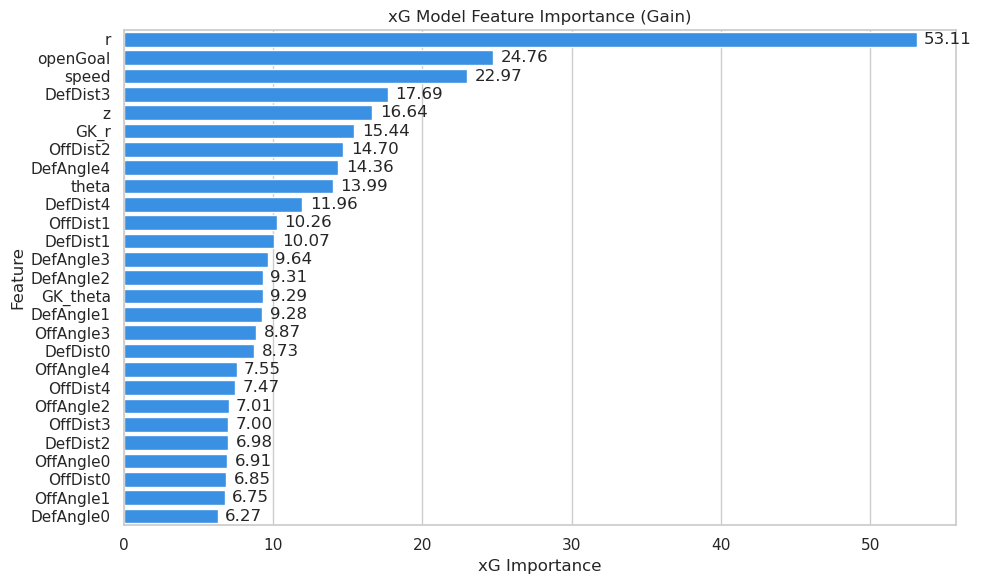

In [58]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=importance_df, x='xG Importance', y='Feature', color='dodgerblue')

for i, (value, feature) in enumerate(zip(importance_df['xG Importance'], importance_df['Feature'])):
    ax.text(value + 0.5, i, f'{value:.2f}', va='center')
    
plt.title("xG Model Feature Importance (Gain)")
plt.tight_layout()
plt.savefig('xG_feature_importance.png')
plt.show()

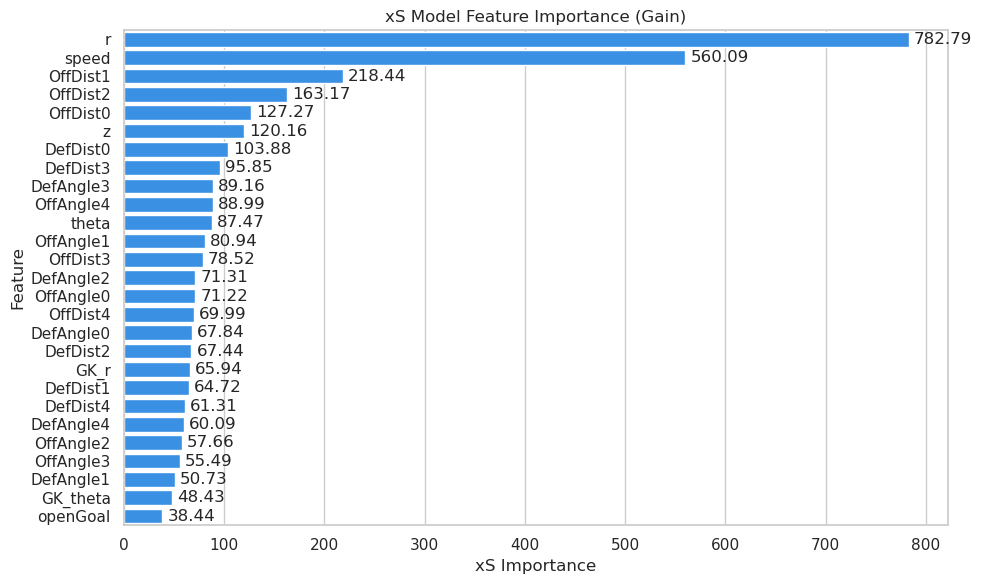

In [63]:
shot_importance_df = importance_df.sort_values(by='xS Importance', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=shot_importance_df, x='xS Importance', y='Feature', color='dodgerblue')

for i, (value, feature) in enumerate(zip(shot_importance_df['xS Importance'], shot_importance_df['Feature'])):
    ax.text(value + 5, i, f'{value:.2f}', va='center')
    
plt.title("xS Model Feature Importance (Gain)")
plt.tight_layout()
plt.savefig('xShot_feature_importance.png')
plt.show()

In [34]:
target = 'hasShotIn1s'
features = ['r', 'theta', 'z', 'speed', 'GK_r', 'GK_theta', 'openGoal']
for i in range(5):
    features += [f'DefDist{i}', f'DefAngle{i}', f'OffDist{i}', f'OffAngle{i}']

Computing PDP for r: 100%|██████████| 50/50 [02:50<00:00,  3.42s/it]


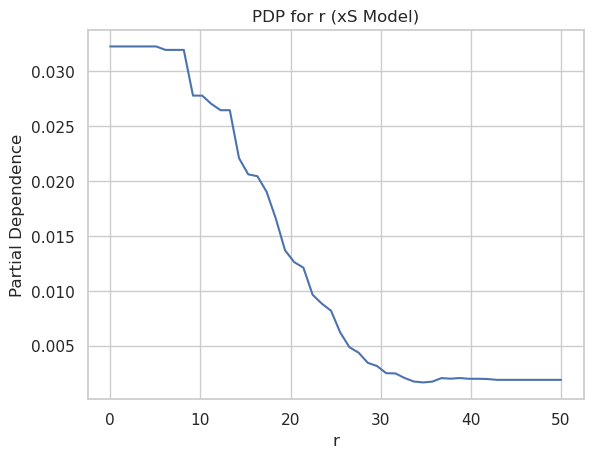

In [64]:
from tqdm import tqdm

partial_features = 'r'
values = np.linspace(0, 50, 50)
pdp_vals = []

X_temp = atk_all[features].copy()
for val in tqdm(values, desc=f'Computing PDP for {partial_features}'):
    X_temp[partial_features] = val
    preds = shot_model.predict(xgb.DMatrix(X_temp))
    pdp_vals.append(np.mean(preds))

plt.plot(values, pdp_vals)
plt.xlabel(partial_features)
plt.ylabel("Partial Dependence")
plt.title(f"PDP for {partial_features} (xS Model)")
plt.grid(True)
plt.savefig(f"xS_PDP_{partial_features}.png")
plt.show()

Computing PDP for speed: 100%|██████████| 50/50 [02:48<00:00,  3.38s/it]


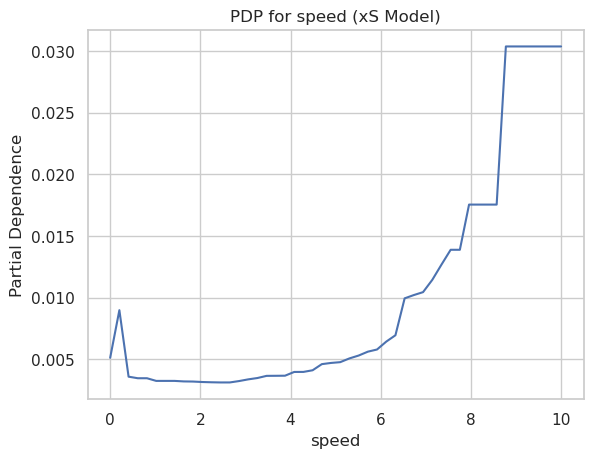

In [82]:
partial_features = 'speed'
values = np.linspace(0, 10, 50)
pdp_vals = []

X_temp = atk_all[features].copy()
for val in tqdm(values, desc=f'Computing PDP for {partial_features}'):
    X_temp[partial_features] = val
    preds = shot_model.predict(xgb.DMatrix(X_temp))
    pdp_vals.append(np.mean(preds))

plt.plot(values, pdp_vals)
plt.xlabel(partial_features)
plt.ylabel("Partial Dependence")
plt.title(f"PDP for {partial_features} (xS Model)")
plt.grid(True)
plt.savefig(f"xS_PDP_{partial_features}.png")
plt.show()

In [66]:
shots = atk_all[atk_all.is_shot]

Computing PDP for r: 100%|██████████| 50/50 [00:00<00:00, 95.04it/s]


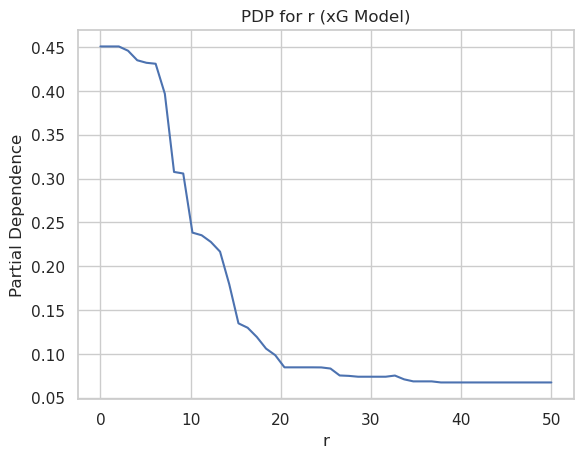

In [72]:
partial_features = 'r'
values = np.linspace(0, 50, 50)
pdp_vals = []

X_temp = shots[features].copy()
for val in tqdm(values, desc=f'Computing PDP for {partial_features}'):
    X_temp[partial_features] = val
    preds = xg_model.predict(xgb.DMatrix(X_temp))
    pdp_vals.append(np.mean(preds))

plt.plot(values, pdp_vals)
plt.xlabel(partial_features)
plt.ylabel("Partial Dependence")
plt.title(f"PDP for {partial_features} (xG Model)")
plt.grid(True)
plt.savefig(f"xG_PDP_{partial_features}.png")
plt.show()

Computing PDP for openGoal: 100%|██████████| 50/50 [00:00<00:00, 94.37it/s]


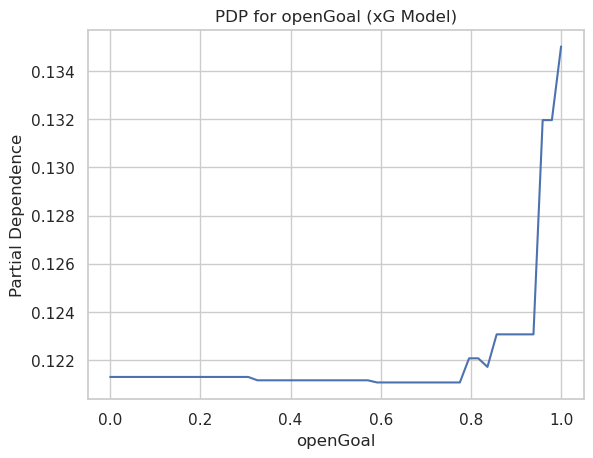

In [73]:
partial_features = 'openGoal'
values = np.linspace(0, 1, 50)
pdp_vals = []

X_temp = shots[features].copy()
for val in tqdm(values, desc=f'Computing PDP for {partial_features}'):
    X_temp[partial_features] = val
    preds = xg_model.predict(xgb.DMatrix(X_temp))
    pdp_vals.append(np.mean(preds))

plt.plot(values, pdp_vals)
plt.xlabel(partial_features)
plt.ylabel("Partial Dependence")
plt.title(f"PDP for {partial_features} (xG Model)")
plt.grid(True)
plt.savefig(f"xG_PDP_{partial_features}.png")
plt.show()

Computing PDP for speed: 100%|██████████| 50/50 [00:00<00:00, 94.25it/s]


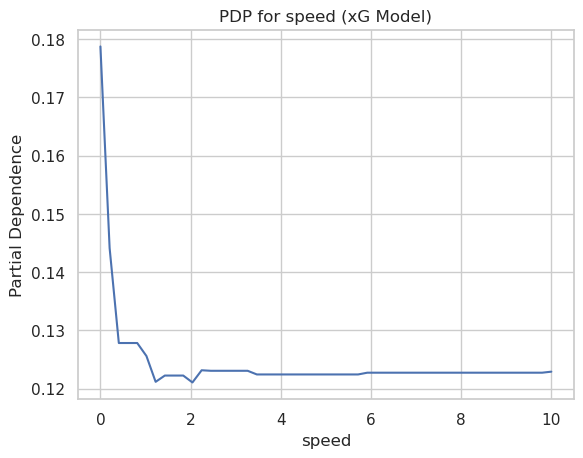

In [80]:
partial_features = 'speed'
values = np.linspace(0, 10, 50)
pdp_vals = []

X_temp = shots[features].copy()
for val in tqdm(values, desc=f'Computing PDP for {partial_features}'):
    X_temp[partial_features] = val
    preds = xg_model.predict(xgb.DMatrix(X_temp))
    pdp_vals.append(np.mean(preds))

plt.plot(values, pdp_vals)
plt.xlabel(partial_features)
plt.ylabel("Partial Dependence")
plt.title(f"PDP for {partial_features} (xG Model)")
plt.grid(True)
plt.savefig(f"xG_PDP_{partial_features}.png")
plt.show()

Computing PDP for z: 100%|██████████| 50/50 [00:00<00:00, 92.12it/s]


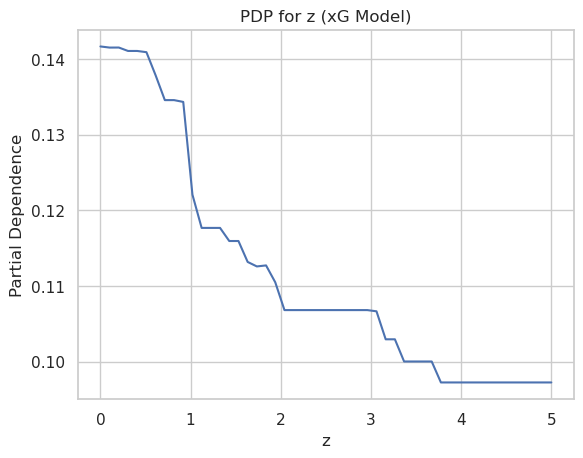

In [79]:
partial_features = 'z'
values = np.linspace(0, 5, 50)
pdp_vals = []

X_temp = shots[features].copy()
for val in tqdm(values, desc=f'Computing PDP for {partial_features}'):
    X_temp[partial_features] = val
    preds = xg_model.predict(xgb.DMatrix(X_temp))
    pdp_vals.append(np.mean(preds))

plt.plot(values, pdp_vals)
plt.xlabel(partial_features)
plt.ylabel("Partial Dependence")
plt.title(f"PDP for {partial_features} (xG Model)")
plt.grid(True)
plt.savefig(f"xG_PDP_{partial_features}.png")
plt.show()